In [17]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim import Adam
from collections import defaultdict

In [2]:
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [3]:
# Set up data loader for MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
def save_model_weights(model, save_path):
    # Save actual weights and biases, not just their sizes
    weights = (
        (model.fc1.weight, model.fc2.weight, model.fc3.weight),
        (model.fc1.bias, model.fc2.bias, model.fc3.bias)
    )
    torch.save(weights, save_path)

In [4]:
def load_and_flatten_weights(model_path):
    weights = torch.load(model_path)
    
    # Flatten the weight and bias sizes
    weight_flat = []
    for w in weights[0]:
        weight_flat.extend(w.view(-1).cpu().detach().numpy())
    
    bias_flat = []
    for b in weights[1]:
        bias_flat.extend(b.view(-1).cpu().detach().numpy())
    
    return np.array(weight_flat + bias_flat)

def plot_saved_weights():
    weights_list = []
    for i in range(1000):
        model_path = f"models/mlp_weights_{i}.pt"
        weights_list.append(load_and_flatten_weights(model_path))

    # Convert the list into a numpy array (shape: [1000, flattened_size])
    weights_matrix = np.array(weights_list)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(weights_matrix)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', s=5)
    plt.title("t-SNE Visualization of 1000 MLP Weight Configurations")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

In [5]:
test_data = datasets.MNIST('.', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
def test_mlp(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [6]:
def generate_and_save_clasifiers():
    os.makedirs('models', exist_ok=True)
    for i in range(535,1000):
        seed = i  # Unique seed for each model initialization
        init_type = 'xavier' if i % 2 == 0 else 'he'
        model = MLP(init_type=init_type, seed=seed)

        # Train the model for a few epochs
        train_mlp(model, epochs=3)

        # Save the weights and biases as tuples of torch.Size
        save_path = f"models/mlp_weights_{i}.pt"
        save_model_weights(model, save_path)
        print(f"Saved model {i} weights to {save_path}")

        accuracy = test_mlp(model, test_loader)
        print(f"Model {i} Test Accuracy: {accuracy:.2f}%")

generate_and_save_clasifiers()

<ipython-input-4-7dcef86ac9bc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_path)


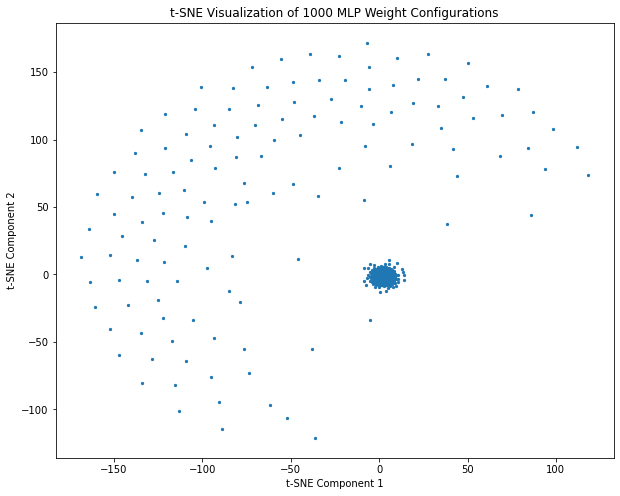

In [7]:
plot_saved_weights()

In [19]:
def convert_to_tensor_format(point):
    """Convert tuple-based weights and biases to tensor-based format"""
    weights_tuple, biases_tuple = point[0], point[1]
    permutations = defaultdict(list)
    for i,(layer_weights,layer_biases) in enumerate(zip(weights_tuple,biases_tuple)): 
        permutations["layer_"+str(i+1)+"_weights"] = np.array(layer_weights.detach().cpu())
        permutations["layer_"+str(i+1)+"_biases"] = np.array(layer_biases.detach().cpu())
    return permutations

In [67]:
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment

def apply_permutations(ps, perm, params_b):
    """
    Apply the calculated permutations to params_b.
    
    Args:
        ps: The permutation structure (providing perm_to_axes).
        perm: The computed permutations (output of weight_matching).
        params_b: The parameters to permute.
    
    Returns:
        A new dictionary with permuted `params_b`.
    """
    permuted_params_b = defaultdict(list)

    for param_name, weights in params_b.items():
        permuted_weights = weights.copy()

        for p, axes in ps.perm_to_axes.items():
            for wk, axis in axes:
                if wk == param_name:
                    permuted_weights = np.take(permuted_weights, perm[p], axis=axis)

        # Store the permuted weights
        permuted_params_b[param_name] = permuted_weights

    return permuted_params_b


def weight_matching(rng, ps, params_a, params_b, max_iter=100, init_perm=None, silent=False):
    """
    Find a permutation of `params_b` to make them match `params_a`.

    Args:
        rng: Random number generator.
        ps: A structure that provides permutation mapping (perm_to_axes).
        params_a: Reference parameters (e.g., from a pre-trained model).
        params_b: Parameters to be permuted (e.g., from another model).
        max_iter: Maximum number of iterations for optimization.
        init_perm: Initial permutation, if any.
        silent: If True, suppress logging.
    Returns:
        A dictionary containing the optimal permutations for each layer.
    """
    perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}
    
    # Initialize permutations
    perm = {p: np.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
    perm_names = list(perm.keys())

    for iteration in range(max_iter):
        progress = False
        # Shuffle layer processing order for robustness
        for p_ix in rng.permutation(len(perm_names)):
            p = perm_names[p_ix]
            n = perm_sizes[p]
            A = np.zeros((n, n))

            # Accumulate similarity matrices across all axes for layer `p`
            for wk, axis in ps.perm_to_axes[p]:
                w_a = params_a[wk]
                if 'bn' in wk or 'downsample.1' in wk:  # Skip normalization layers
                    w_b = w_a.copy()
                else:
                    # Get permuted version of params_b for current axis
                    w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)

                # Reshape and compute contribution to similarity matrix
                w_a = np.moveaxis(w_a, axis, 0).reshape((n, -1))
                w_b = np.moveaxis(w_b, axis, 0).reshape((n, -1))
                A += w_a @ w_b.T

            # Solve assignment problem to find the best permutation
            ri, ci = linear_sum_assignment(A, maximize=True)
            assert (ri == np.arange(len(ri))).all()  # Sanity check

            # Compute alignment scores before and after permutation
            oldL = np.vdot(A, np.eye(n)[perm[p]])
            newL = np.vdot(A, np.eye(n)[ci, :])
            if not silent:
                print(f"Iteration {iteration} - Layer {p}: Score improvement {newL - oldL:.6f}")

            # Update permutation if there is an improvement
            progress = progress or newL > oldL + 1e-12
            perm[p] = np.array(ci)

        # Exit if no improvement is observed
        if not progress:
            break

    return perm

In [82]:
import numpy as np

# Define a mock permutation structure
class PermStructure:
    def __init__(self, perm_to_axes):
        self.perm_to_axes = perm_to_axes

# Define `get_permuted_param` function
def get_permuted_param(ps, perm, param_name, params, except_axis):
    """
    Get permuted parameter based on current permutations.
    """
    w = params[param_name]
    for p, axes in ps.perm_to_axes.items():
        for wk, axis in axes:
            if wk == param_name and axis != except_axis:
                w = np.take(w, perm[p], axis=axis)
    return w

# Define permutation mapping (example for 3 layers)
perm_to_axes = {
    "layer_1": [("layer_1_weights", 0)],
    "layer_2": [("layer_2_weights", 0)],
    "layer_3": [("layer_3_weights", 0)],
}

# Instantiate permutation structure
ps = PermStructure(perm_to_axes)

# Initialize random generator
rng = np.random.default_rng(42)

In [85]:
# Call weight_matching function
ref_point = torch.load('models/mlp_weights_0.pt')
ref_data_param = convert_to_tensor_format(ref_point)

permuted_params = []
data_point_params = []
for i in range(1,1000):
    model_path = f"models/mlp_weights_{i}.pt"
    data = torch.load(model_path)
    data_params = convert_to_tensor_format(data)
    permutations = weight_matching(rng, ps, ref_data_param, data_params)
    permuted_param = apply_permutations(ps, permutations, data_params)
    permuted_params.append(permuted_param)
    data_point_params.append(data_params)

<ipython-input-85-657d9b7d5a2c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ref_point = torch.load('models/mlp_weights_0.pt')
<ipython-input-85-657d9b7d5a2c>:9: FutureW

Iteration 0 - Layer layer_3: Score improvement 3.375455
Iteration 0 - Layer layer_2: Score improvement 13.835423
Iteration 0 - Layer layer_1: Score improvement 23.792656
Iteration 1 - Layer layer_1: Score improvement 0.000000
Iteration 1 - Layer layer_3: Score improvement 0.000000
Iteration 1 - Layer layer_2: Score improvement 0.000000
Iteration 0 - Layer layer_2: Score improvement 12.284743
Iteration 0 - Layer layer_3: Score improvement 5.039753
Iteration 0 - Layer layer_1: Score improvement 29.260350
Iteration 1 - Layer layer_3: Score improvement 0.000000
Iteration 1 - Layer layer_1: Score improvement 0.000000
Iteration 1 - Layer layer_2: Score improvement 0.000000
Iteration 0 - Layer layer_3: Score improvement 4.178652
Iteration 0 - Layer layer_1: Score improvement 26.703657
Iteration 0 - Layer layer_2: Score improvement 14.677910
Iteration 1 - Layer layer_1: Score improvement 0.000000
Iteration 1 - Layer layer_3: Score improvement 0.000000
Iteration 1 - Layer layer_2: Score improve

In [95]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def flatten_and_concatenate(params):
    """Flatten the weights and biases for each layer and concatenate them."""
    flattened_params = []
    for layer in list(params.keys()):
        if 'weights' in layer:
            # Flatten the weights
            layer_weights = np.array(params[layer]).flatten()
            flattened_params.append(layer_weights)
        elif 'biases' in layer:
            # Flatten the biases
            layer_biases = np.array(params[layer]).flatten()
            flattened_params.append(layer_biases)
    
    # Return a single concatenated vector for all layers in the dictionary
    return np.concatenate(flattened_params)

def plot_tsne(reference_param, permuted_params_list, data_point_params):
    """Plot t-SNE of weights and biases from the reference_param, permuted_params_list, and data_points."""
    
    # Flatten and concatenate the reference parameter (ref_point)
    flattened_reference = flatten_and_concatenate(reference_param)
        
    # Initialize the list of flattened params for all permuted parameters
    all_params = [flattened_reference]
    
    # Flatten and concatenate all permuted parameters
    for permuted_params in permuted_params_list:
        flattened_permuted_param = flatten_and_concatenate(permuted_params)
        all_params.append(flattened_permuted_param)
    
    # Flatten and concatenate all data points
    for data in data_point_params:
        flattened_data = flatten_and_concatenate(data)
        all_params.append(flattened_data)
    
    # Perform t-SNE to reduce the dimensions to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)
    tsne_results = tsne.fit_transform(np.vstack(all_params))
    
    # Plot the t-SNE results
    plt.figure(figsize=(12, 8))
    
    # Plot the permuted parameters
    for i, tsne_result in enumerate(tsne_results[1:len(permuted_params_list)+1], 1):
        if i == 1:
            plt.scatter(tsne_result[0], tsne_result[1], label=f'Permuted Params', color='green')
        else:
            plt.scatter(tsne_result[0], tsne_result[1], color='green')
    
    # Plot the original data points
    for i, tsne_result in enumerate(tsne_results[len(permuted_params_list)+1:], 1):
        if i == 1:
            plt.scatter(tsne_result[0], tsne_result[1], label=f'Original Params', color='blue')
        else:
            plt.scatter(tsne_result[0], tsne_result[1], color='blue')
                    
    # Plot reference point
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], label='Reference (ref_point)', color='red', marker='X')
    
    # Add titles and labels
    plt.title("t-SNE visualization of weights and biases for 1 reference parameter, permuted params, and data points")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    
    # Show plot
    plt.show()

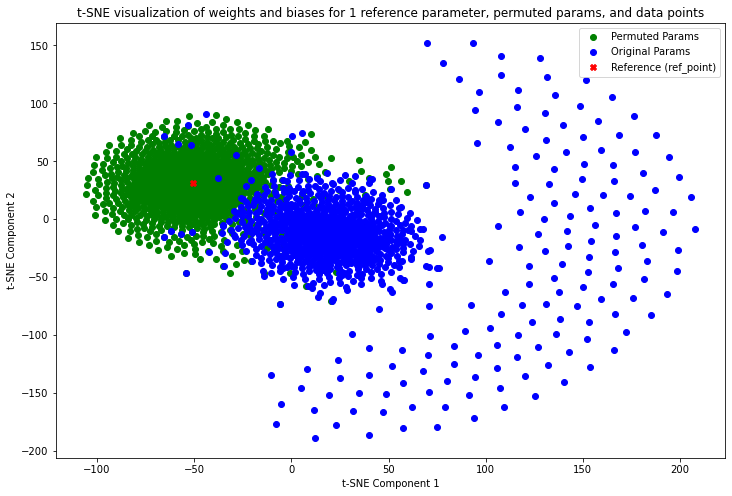

In [96]:
plot_tsne(ref_data_param, permuted_params, data_point_params)